# Coffee Data: exploration ☕☕☕

The data is gathered from Coffee Quality Institute (CQI) in January, 2018. Scraping was performed by [James LeDoux](https://github.com/jldbc) and more details can be found [here](https://github.com/jldbc/coffee-quality-database).

## Summary
- the dataset is rather small (this could potentially be changed by scraping a more recent version of the data)
- there are quite a few missing values, some I chose to replace with an average or label as missing however I droped quite a few rows which contained missing information such as region or variety
- the dataset after processing has 894 rows
- the target value `total_cup_score` has 5% of the values over 85 (this will likely be our classification threshold)
- most samples are Arabica, a lot of Robusta samples had missing values
- The features that seem to correlate the most with the total cup score are the number of quakers (unripe coffee)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score

from data_prep import handle_na_values, split_data, convert_bag_weight

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("../data/merged_data_cleaned.csv",  index_col=0)

In [3]:
len(df)

1339

In [4]:
df.columns = df.columns.str.lower().str.replace(".", "_")

/tmp/ipykernel_128/4262472041.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.replace(".", "_")


In [5]:
df.head()

,species,owner,country_of_origin,farm_name,lot_number,mill,ico_number,company,altitude,region,...,color,category_two_defects,expiration,certification_body,certification_address,certification_contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,NaN,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,oromia,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


### Feature separation

In [6]:
df["lot_number"].value_counts()

1               18
020/17           6
019/17           5
2                3
103              3
                ..
8885             1
5055             1
MCCFWXA15/16     1
73               1
Lavado 3         1
Name: lot_number, Length: 227, dtype: int64

In [7]:
df["ico_number"].value_counts()

0                    77
Taiwan               31
2222                 11
-                     9
Taiwan台灣              7
                     ..
033/0004              1
543                   1
11/11711/58           1
13-63-214             1
14-1118-2014-0087     1
Name: ico_number, Length: 847, dtype: int64

In [8]:
processing_features = ["species", "owner", "country_of_origin", "farm_name",
       "mill", "company", "altitude", "region", "producer",
       "number_of_bags", "bag_weight", "in_country_partner",
       "harvest_year", "grading_date", "owner_1", "variety",
       "processing_method"]

In [9]:
green_features = ["moisture", "category_one_defects", "quakers",
        "color", "category_two_defects"]

In [10]:
quality_features = ["aroma", "flavor", "aftertaste", "acidity",
       "body", "balance", "uniformity", "clean_cup", "sweetness",
       "cupper_points", "total_cup_points"]

In [11]:
cert_info = ["expiration", "certification_body", "certification_address",
       "certification_contact", "unit_of_measurement",
       "altitude_low_meters", "altitude_high_meters",
       "altitude_mean_meters"]

In [12]:
df["bag_weight"].unique()

array(['60 kg', '1', '30 kg', '69 kg', '1 kg', '2 kg,lbs', '6', '3 lbs',
       '50 kg', '2 lbs', '100 lbs', '15 kg', '2 kg', '2', '70 kg',
       '19200 kg', '5 lbs', '1 kg,lbs', '6 kg', '0 lbs', '46 kg', '40 kg',
       '20 kg', '34 kg', '1 lbs', '660 kg', '18975 kg', '12000 kg',
       '35 kg', '66 kg', '80 kg', '132 lbs', '5 kg', '25 kg', '59 kg',
       '18000 kg', '150 lbs', '9000 kg', '18 kg', '10 kg', '29 kg',
       '1218 kg', '4 lbs', '0 kg', '13800 kg', '1500 kg', '24 kg',
       '80 lbs', '8 kg', '3 kg', '350 kg', '67 kg', '4 kg', '55 lbs',
       '100 kg', '130 lbs'], dtype=object)

In [13]:
df["bag_weight"] = df["bag_weight"].apply(lambda weight_str: convert_bag_weight(weight_str))

🔍 A few of the columns such as ico number or lot number I have removed as they have many missing values and contextually don"t add much value. I further split the columns in to categories for what they describe. The quality features will be my target variables, for now I will look at the `total_cup_points`. The bag weight column has to be converted from a string to a number (weight in kg).

### Handling empty/ null values

In [14]:
df.isnull().sum()

species                     0
owner                       7
country_of_origin           1
farm_name                 359
lot_number               1063
mill                      318
ico_number                157
company                   209
altitude                  226
region                     59
producer                  232
number_of_bags              0
bag_weight                 27
in_country_partner          0
harvest_year               47
grading_date                0
owner_1                     7
variety                   226
processing_method         170
aroma                       0
flavor                      0
aftertaste                  0
acidity                     0
body                        0
balance                     0
uniformity                  0
clean_cup                   0
sweetness                   0
cupper_points               0
total_cup_points            0
moisture                    0
category_one_defects        0
quakers                     1
color     

In [15]:
df = handle_na_values(df)

In [16]:
len(df)

894

## Exploration of raw coffee attributes

Here we look at both the `processing_features` and `green_features` as these will likely provide the features for our model.

<AxesSubplot:title={'center':'Coffee altitudes'}, xlabel='Altitude', ylabel='Number of samples'>

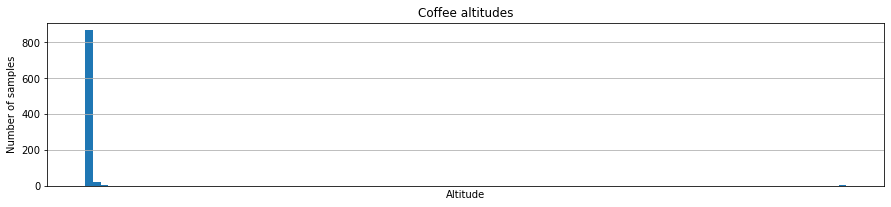

In [17]:
plt.figure(figsize=(15,3))
plt.xticks([])
plt.xlabel("Altitude")
plt.ylabel("Number of samples")
plt.title("Coffee altitudes")

df["altitude_mean_meters"].hist(bins=100)

<AxesSubplot:title={'center':'Coffee altitudes under 1600 (long tail removed)'}, xlabel='Altitude', ylabel='Number of samples'>

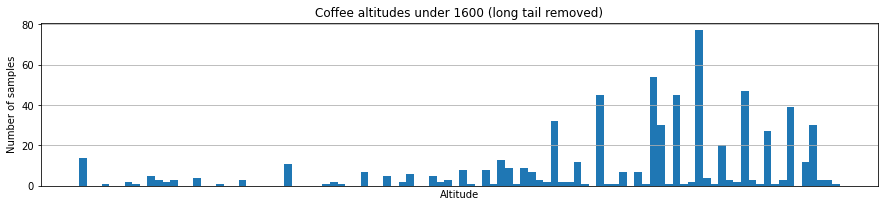

In [18]:
plt.figure(figsize=(15,3))
plt.xticks([])
plt.xlabel("Altitude")
plt.ylabel("Number of samples")
plt.title("Coffee altitudes under 1600 (long tail removed)")

df[df["altitude_mean_meters"]< 1600]["altitude_mean_meters"].hist(bins=100)

In [19]:
df["country_of_origin"].value_counts()

Mexico                          198
Guatemala                       149
Colombia                        109
Brazil                           95
Taiwan                           63
Costa Rica                       44
Honduras                         41
Tanzania, United Republic Of     35
Uganda                           24
Kenya                            19
China                            16
Indonesia                        13
El Salvador                      13
Nicaragua                        12
Malawi                           11
Ethiopia                          8
Thailand                          7
Myanmar                           7
Vietnam                           6
United States (Puerto Rico)       4
Haiti                             4
Philippines                       4
Panama                            3
Laos                              3
United States                     2
India                             2
Rwanda                            1
Peru                        

<BarContainer object of 5 artists>

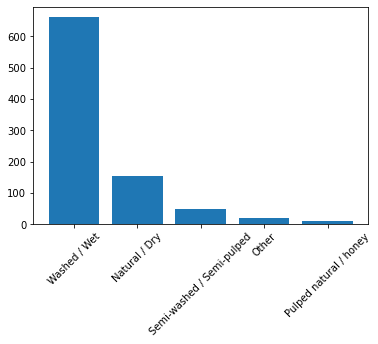

In [20]:
processing_methods = df["processing_method"].value_counts()
plt.xticks(rotation=45)
plt.bar(processing_methods.index, processing_methods.values)

([<matplotlib.patches.Wedge at 0x7f2847bdbd30>,
 [Text(-1.0999388748437207, 0.011596189353832071, 'Arabica'),
  Text(1.0999388756749673, -0.011596110506928974, 'Robusta')])

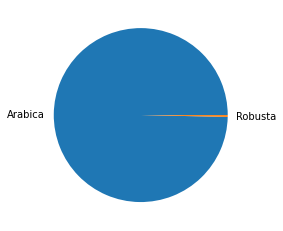

In [21]:
species = df["species"].value_counts()
plt.pie(species.values, labels=species.index)

🔍 Note that if we don"t drop the nan values there are slightly more Robusta samples, meaning many of them have missing data.

<BarContainer object of 25 artists>

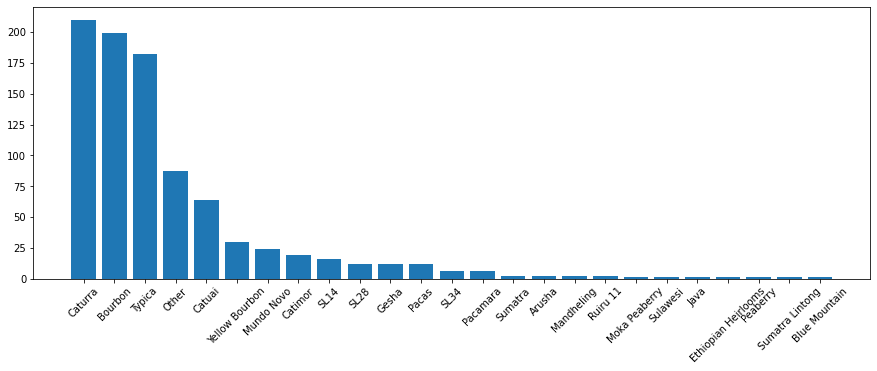

In [22]:
variety = df["variety"].value_counts()

plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
plt.bar(variety.index, variety.values)

🔍 Most samples are Arabic with very few Robusta samples. There is a long tail distribution of Varieties which makes sense as there are the more popular varieties planted and some more speciality or less common. Most samples have a mean altitude under 1600 meters and are washed processed coffee. A large amount of these samples are from south and central America with Mexico, Guatemala, Colombia, and Brazil being the origins with the most samples. 

## Exploration of coffee quality attributes ( both green and roasted)

The quality will be what I want to predict, to begin with I will focus on the `total_cup_points` and see if I can predict this from the `green_features` and `processing_features`.

In [23]:
df[quality_features].describe().T

,count,mean,std,min,25%,50%,75%,max
aroma,894.0,7.558881,0.294818,5.08,7.42,7.58,7.75,8.75
flavor,894.0,7.504116,0.310404,6.17,7.33,7.50,7.67,8.67
aftertaste,894.0,7.374407,0.323754,6.17,7.17,7.42,7.58,8.50
acidity,894.0,7.515324,0.300097,5.25,7.33,7.50,7.67,8.58
body,894.0,7.493535,0.264954,6.33,7.33,7.50,7.67,8.42
balance,894.0,7.488020,0.334974,6.08,7.33,7.50,7.67,8.58
uniformity,894.0,9.870817,0.442629,6.00,10.00,10.00,10.00,10.00
clean_cup,894.0,9.848535,0.770526,0.00,10.00,10.00,10.00,10.00
sweetness,894.0,9.930459,0.438240,1.33,10.00,10.00,10.00,10.00
cupper_points,894.0,7.459441,0.389179,5.17,7.25,7.50,7.67,8.58


<AxesSubplot:>

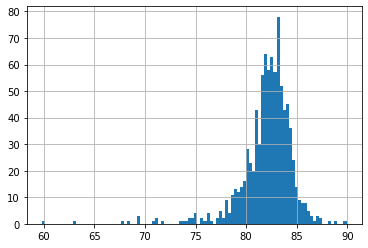

In [24]:
df["total_cup_points"].hist(bins=100)

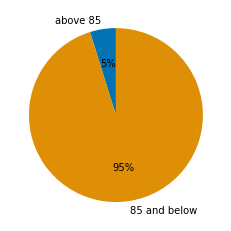

In [25]:
above_85 = len(df[df["total_cup_points"] > 85])
below_85 = len(df[df["total_cup_points"] <= 85])

colors = sns.color_palette("colorblind")[0:5]

plt.pie([above_85, below_85], labels=["above 85", "85 and below"], colors=colors, startangle = 90, autopct="%.0f%%")
plt.show()

<AxesSubplot:>

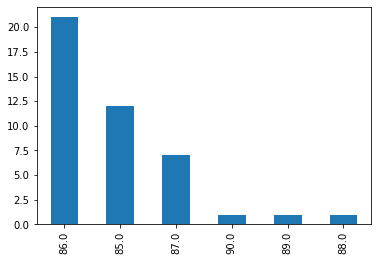

In [26]:
df[df["total_cup_points"] > 85]["total_cup_points"].round().value_counts().plot(kind="bar")

In [27]:
print(f"{(100 / len(df)) * len(df[df['total_cup_points'] > 85]):.2f}% of samples recieved a total cupping score over 85")

4.81% of samples recieved a total cupping score over 85


🔍 A high total cupping score has an impact on how much a coffee can be sold for as it is an indication of overall quality. The scores are given by tasting the coffee samples in a process called cupping where samples are evaluated on sweetness, aroma, cleanliness, balance and other qualities by coffee professionals. Attributes such as the moisture value, the number of quakers or defects are assessed from the green raw product and along with processing techniques, varietal, and the altitude the tree is grown at indicate the quality of a coffee sample.

## Splitting the data

In [28]:
features = green_features + processing_features

In [29]:
df_train, df_val, df_test, y_train, y_val, y_test, df_full_train = split_data(df, features)

length of training set: 536, validation set: 179, test set: 179


## Feature correlation

In [30]:
df[features].dtypes

moisture                float64
category_one_defects      int64
quakers                 float64
color                    object
category_two_defects      int64
species                  object
owner                    object
country_of_origin        object
farm_name                object
mill                     object
company                  object
altitude                 object
region                   object
producer                 object
number_of_bags            int64
bag_weight               object
in_country_partner       object
harvest_year             object
grading_date             object
owner_1                  object
variety                  object
processing_method        object
dtype: object

In [31]:
numerical_features = [
    "moisture",
    "category_one_defects",
    "quakers",
    "category_two_defects",
    "altitude",
    "number_of_bags",
    "bag_weight"
]

categorical_features = [
    "color",
    "species",
    "owner",
    "country_of_origin",
    "farm_name",
    "mill",
    "company",
    "region",
    "producer",
    "in_country_partner",
    "harvest_year",
    "owner_1",
    "variety",
    "processing_method"
]

In [32]:
def mutual_info_total_cup_score(series):
    return mutual_info_score(series, df_full_train["total_cup_points"])

In [33]:
mi = df_full_train[categorical_features].apply(mutual_info_total_cup_score)
mi.sort_values(ascending=False)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/conda/lib/p

producer              3.561634
farm_name             3.153362
mill                  2.985405
region                2.740557
owner_1               2.489754
owner                 2.481078
company               2.479748
country_of_origin     1.016673
in_country_partner    0.988320
variety               0.765438
harvest_year          0.616748
color                 0.235633
processing_method     0.230606
species               0.015306
dtype: float64

In [34]:
features = green_features + processing_features
df[features].describe().T

,count,mean,std,min,25%,50%,75%,max
moisture,894.0,0.097371,0.041413,0.0,0.1,0.11,0.12,0.17
category_one_defects,894.0,0.426174,2.045022,0.0,0.0,0.00,0.00,31.00
quakers,894.0,0.152125,0.755207,0.0,0.0,0.00,0.00,11.00
category_two_defects,894.0,3.822148,5.610612,0.0,0.0,2.00,5.00,47.00
number_of_bags,894.0,157.865772,126.458080,1.0,20.0,200.00,275.00,600.00


In [35]:
df["quakers"].value_counts()

0.0     834
1.0      26
2.0      21
4.0       3
3.0       3
5.0       3
11.0      1
7.0       1
6.0       1
8.0       1
Name: quakers, dtype: int64

<AxesSubplot:>

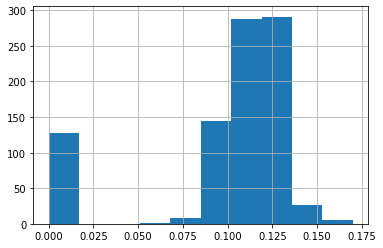

In [36]:
df["moisture"].hist()

In [37]:
df_full_train[numerical_features].corrwith(df_full_train["total_cup_points"])

moisture               -0.151336
category_one_defects   -0.127726
quakers                 0.021064
category_two_defects   -0.320109
number_of_bags          0.038112
dtype: float64

<AxesSubplot:xlabel='category_two_defects', ylabel='total_cup_points'>

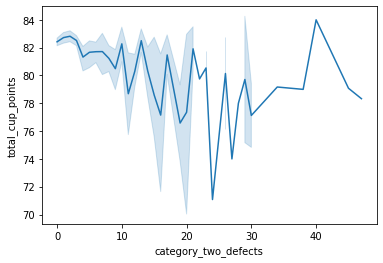

In [38]:
sns.lineplot(x=df_full_train["category_two_defects"], y=df_full_train["total_cup_points"])

🔍 As the number of defects increases the total number of cupping points goes down, though we do see a spike in the later half of this graph I would suggest this is a error / outlier in the data.

<AxesSubplot:>

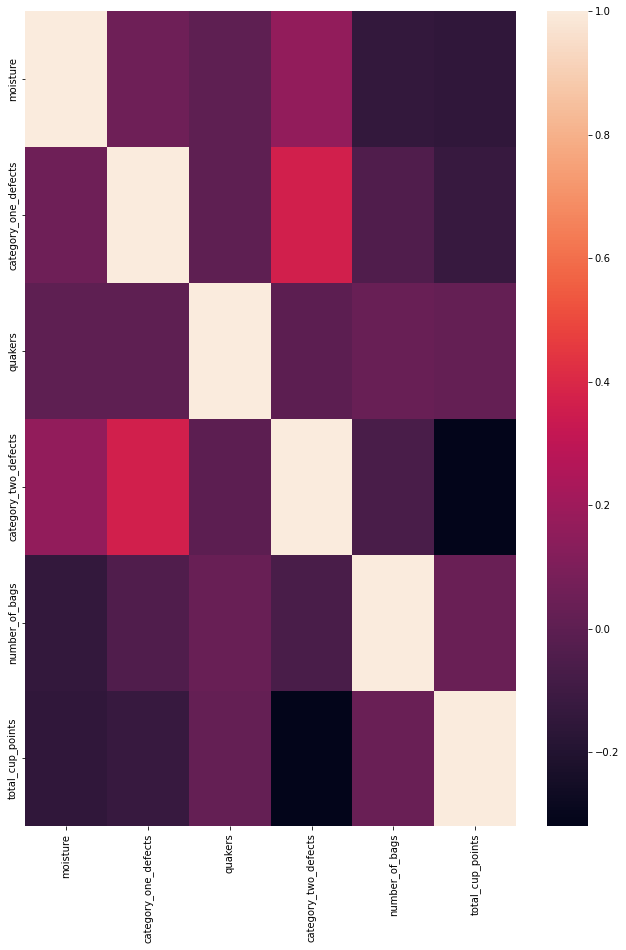

In [39]:
correlations = df_full_train[features + ["total_cup_points"]].corr()
plt.figure(figsize=(11, 15))
sns.heatmap(correlations)

🔍 The features that seem to correlate the most with the total cup score are the number of quakers (unripe coffee) which makes sense as this is also considered a defect. Interesting the number of bags appears to be closely correlated to the total cup points but this seems unlikely to be a direct correlation and perhaps indirectly the case as more bags may be available for higher quality coffees. 

Category one and two defects have a correlation which makes sense that a coffee containing defects of one sort may also have the other. Another interesting observation is the correlation between moisture and quakers and category one defects, this seems quite logical as unripe and defected beans could be expected to have a different moisture level.